# Image Interpolation Techniques

This notebook demonstrates manual, vectorized implementations of three fundamental image scaling algorithms: **Nearest Neighbor**, **Bilinear**, and **Bicubic** interpolation. These methods are used to reconstruct high-resolution images from downsampled inputs.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1. Setup & Downsampling
We load the image and shrink it to a 64x64 resolution to create a low-res source for our interpolation tests.

In [2]:
def load_and_prep():
    # Load image
    img = cv2.imread('tiger.png')
    if img is None:
        raise FileNotFoundError("tiger.png not found")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Downsample to 64x64 using Area interpolation
    small = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    return img, small

### 2. Manual Nearest Neighbor (Vectorized)
The simplest form of interpolation, which selects the value of the nearest pixel in the original image.

In [3]:
def manual_nearest_neighbor(img, new_shape):
    old_h, old_w = img.shape[:2]
    new_h, new_w = new_shape
    
    row_grid = np.arange(new_h).reshape(-1, 1)
    col_grid = np.arange(new_w).reshape(1, -1)
    
    r_scale = old_h / new_h
    c_scale = old_w / new_w
    
    src_r = (row_grid * r_scale).astype(np.int32)
    src_c = (col_grid * c_scale).astype(np.int32)
    
    src_r = np.clip(src_r, 0, old_h - 1)
    src_c = np.clip(src_c, 0, old_w - 1)
    
    return img[src_r, src_c]

### 3. Manual Bilinear Interpolation (Vectorized)
Bilinear interpolation calculates the weighted average of the 2x2 neighborhood of pixels surrounding the target coordinate.

In [4]:
def manual_bilinear(img, new_shape):
    old_h, old_w, c = img.shape
    new_h, new_w = new_shape
    
    row_grid = np.arange(new_h).reshape(-1, 1)
    col_grid = np.arange(new_w).reshape(1, -1)
    
    scale_y = old_h / new_h
    scale_x = old_w / new_w
    
    src_y = row_grid * scale_y
    src_x = col_grid * scale_x
    
    y0 = np.floor(src_y).astype(np.int32)
    x0 = np.floor(src_x).astype(np.int32)
    
    y1 = np.clip(y0 + 1, 0, old_h - 1)
    x1 = np.clip(x0 + 1, 0, old_w - 1)
    y0 = np.clip(y0, 0, old_h - 1)
    x0 = np.clip(x0, 0, old_w - 1)
    
    dy = (src_y - y0)[:, :, np.newaxis]
    dx = (src_x - x0)[:, :, np.newaxis]
    
    p00 = img[y0, x0]
    p01 = img[y0, x1]
    p10 = img[y1, x0]
    p11 = img[y1, x1]
    
    top = p00 * (1 - dx) + p01 * dx
    bottom = p10 * (1 - dx) + p11 * dx
    final = top * (1 - dy) + bottom * dy
    
    return final.astype(np.uint8)

### 4. Manual Bicubic Interpolation (Vectorized)
Bicubic interpolation uses a 4x4 neighborhood and a cubic spline weight function to produce smoother results than bilinear interpolation.

In [5]:
def manual_bicubic(img, new_shape):
    old_h, old_w, channels = img.shape
    new_h, new_w = new_shape
    
    def get_weights(t):
        t = np.abs(t)
        w = np.zeros_like(t)
        mask1 = t <= 1
        w[mask1] = 1.5 * t[mask1]**3 - 2.5 * t[mask1]**2 + 1
        mask2 = (t > 1) & (t <= 2)
        w[mask2] = -0.5 * t[mask2]**3 + 2.5 * t[mask2]**2 - 4 * t[mask2] + 2
        return w

    row_grid = np.arange(new_h).reshape(-1, 1)
    col_grid = np.arange(new_w).reshape(1, -1)
    
    src_y = row_grid * (old_h / new_h)
    src_x = col_grid * (old_w / new_w)
    y_int = np.floor(src_y).astype(np.int32)
    x_int = np.floor(src_x).astype(np.int32)
    
    output = np.zeros((new_h, new_w, channels), dtype=np.float32)
    
    for m in range(-1, 3):
        for n in range(-1, 3):
            y_idx = np.clip(y_int + m, 0, old_h - 1)
            x_idx = np.clip(x_int + n, 0, old_w - 1)
            pixels = img[y_idx, x_idx]
            wy = get_weights(src_y - (y_int + m))
            wx = get_weights(src_x - (x_int + n))
            weight = (wy * wx)[:, :, np.newaxis]
            output += pixels * weight
            
    return np.clip(output, 0, 255).astype(np.uint8)

### 5. Main Execution & Comparison

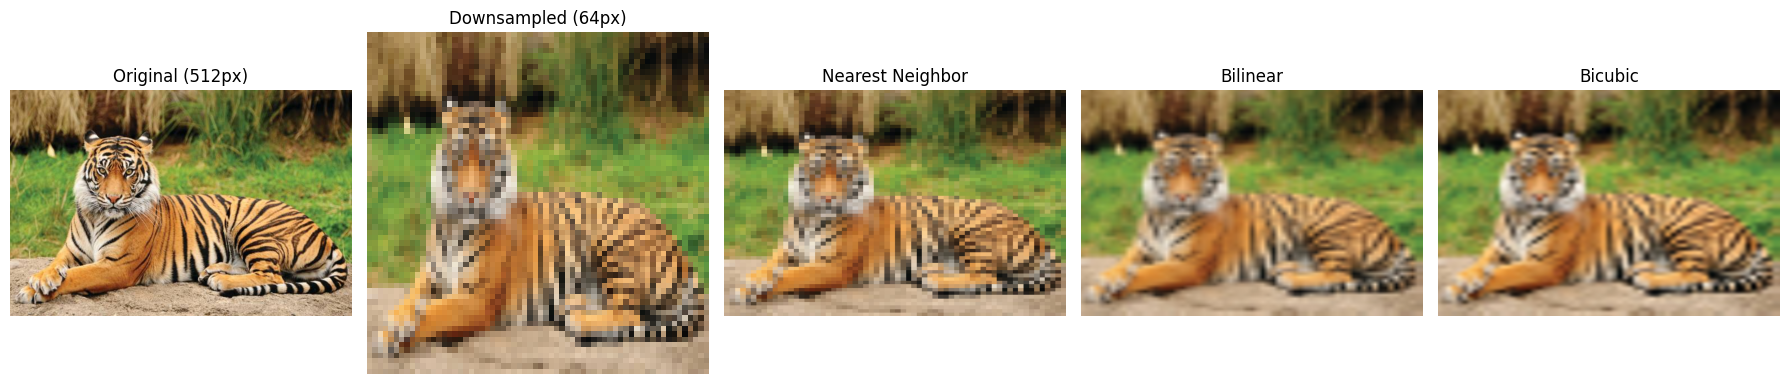

In [6]:
try:
    original, downsampled = load_and_prep()
    target_h, target_w = original.shape[:2]
    
    res_nn = manual_nearest_neighbor(downsampled, (target_h, target_w))
    res_bil = manual_bilinear(downsampled, (target_h, target_w))
    res_bic = manual_bicubic(downsampled, (target_h, target_w))
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 5, 1); plt.title("Original (512px)"); plt.imshow(original); plt.axis('off')
    plt.subplot(1, 5, 2); plt.title("Downsampled (64px)"); plt.imshow(downsampled); plt.axis('off')
    plt.subplot(1, 5, 3); plt.title("Nearest Neighbor"); plt.imshow(res_nn); plt.axis('off')
    plt.subplot(1, 5, 4); plt.title("Bilinear"); plt.imshow(res_bil); plt.axis('off')
    plt.subplot(1, 5, 5); plt.title("Bicubic"); plt.imshow(res_bic); plt.axis('off')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {e}")